# Install Packages for DietVision

In [42]:
import sys
!{sys.executable} -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision matplotlib
!{sys.executable} -m pip install -q segment-anything gradio datasets transformers torch torchvision numpy Pillow


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


# Set up GPU and create a Mask Generator

In [43]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

HOME = os.getcwd() # /apps

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks of a test image

In [44]:
import cv2
import numpy as np

IMAGE_NAME = 'fish_chips.jpg'
IMAGE_DIRECTORY = os.path.join(HOME, 'images')
IMAGE_PATH = os.path.join(IMAGE_DIRECTORY, IMAGE_NAME)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

good /Users/EKim45/Projects/academic/nyu_diet_vision/apps/images/fish_chips.jpg


# Plot Masks and Annotated Image in Grid

In [49]:
from PIL import Image
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

def plot_annotation_grid():
  sv.plot_images_grid(
      images = [image_bgr, annotated_image],
      grid_size = (1, 2),
      titles = ['source image', 'segmented image']
  )

def plot_masks_grid():
  masks = [
      mask['segmentation']
      for mask
      in sorted(sam_result, key=lambda x: x['area'], reverse=True)
  ]

  sv.plot_images_grid(
      images=masks,
      grid_size =(16, int(len(masks) / 6)),
      size=(16, 16)
  )

In [118]:
masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

h, w = masks[0].shape

mask_dictionary = np.full((h, w), -1)

In [120]:
diet_vision_data = [{
    'mask': mask['segmentation'],
    'area': mask['area'],
    'class': None,
    'redirect': -1,
} for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

DIET_VISION_DICTIONARY = {}

for idx, m in enumerate(diet_vision_data):
    DIET_VISION_DICTIONARY.update({ idx: m })

In [121]:
from matplotlib import pyplot as plt
import random

def plot_image_by_ndarray(nda: np.ndarray):
    plt.imshow(nda)
    plt.show()

def spot_annotator(index: int) -> np.ndarray:
    cp = sv.ColorPalette.default()
    idx = random.choice(range(len(cp.colors)))

    img = image_rgb.copy()
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[:] = cp.by_idx(idx).as_bgr()
    opacity: float = 0.5

    return np.where(
        np.expand_dims(masks[index],axis=-1),
        np.uint8(opacity*colored_mask + (1-opacity)*img), 
        img,
    )

def init_mask_dictionary(ms: np.ndarray, md: np.ndarray):
    for mi in range(len(ms)):
        mask = ms[mi]
        for row in range(h): # y
            for col in range(w): # x
                if mask[row][col]:
                    if md[row][col] == -1:
                        md[row][col] = mi

def count_non_negative_spot(md: np.ndarray):
    count = 0

    for row in range(len(md)):
        for col in range(len(md[0])):
            if md[row][col] != -1:
                count += 1
    return count

In [122]:
init_mask_dictionary(masks, mask_dictionary)

print(f'diff: {(h*w)-count_non_negative_spot(mask_dictionary)}') # diff: 171412
print(f'total pixel: {h*w}') # total pixel: 5018112

print(masks[0][100][100])
print(mask_dictionary[1074][1725])

diff: 171412
total pixel: 5018112
True
1


<class 'numpy.ndarray'>


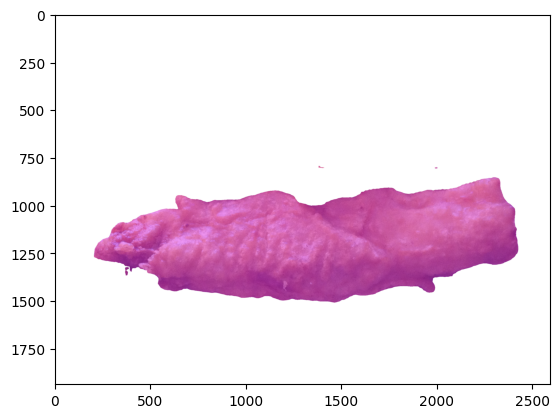

In [180]:
blank_white_image = 255 * np.ones((h, w, 3), dtype = np.uint8)
transparent_image = Image.open('../apps/images/blank_transparent_image.png')
transparent_image_copy = transparent_image.copy()
transparent_image_copy = transparent_image_copy.convert('RGB')
transparent_image_copy = np.array(transparent_image_copy)

print(type(transparent_image_copy))

def spot_annotator2(index: int) -> np.ndarray:
    cp = sv.ColorPalette.default()
    idx = random.choice(range(len(cp.colors)))

    img = image_rgb.copy()
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[:] = cp.by_idx(idx).as_bgr()
    opacity: float = 0.5

    return np.where(
        np.expand_dims(masks[index],axis=-1),
        np.uint8(opacity*colored_mask + (1-opacity)*img), 
        transparent_image_copy,
    )

plot_image_by_ndarray(spot_annotator2(1))

In [168]:
blank_white_image_data = Image.fromarray(blank_white_image)
blank_white_image_data.save('../apps/images/blank_white_image.jpg')

In [171]:
opc: float = 0.5

im_rgb = Image.open('../apps/images/blank_white_image.jpg')
im_rgba = im_rgb.copy()
im_rgba = im_rgba.convert('RGBA')
im_rgba_data = im_rgba.getdata()
im_rgba_new_data = []

for item in im_rgba_data:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        im_rgba_new_data.append((255, 255, 255, 0))
    else:
        im_rgba_new_data.append(item)

# transparent_image = image_rgb.copy().putalpha(128)
# plot_image_by_ndarray(transparent_image)

im_rgba.putdata(im_rgba_new_data)
im_rgba.save('../apps/images/blank_transparent_image.png', "PNG")

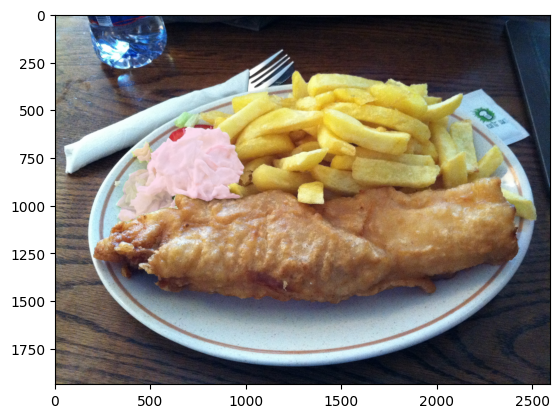

In [205]:
plot_image_by_ndarray(spot_annotator(5))

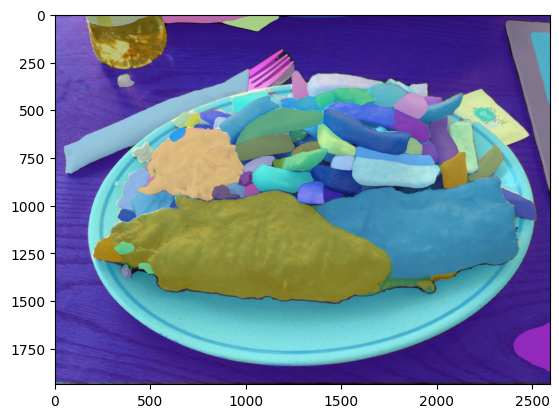

In [200]:
plot_image_by_ndarray(annotated_image)

In [201]:
import IPython

IPython.display.HTML("""
<script>
    let isDrag = false;
    var dragDiv = document.getElementById('draggable-div');
    dragDiv.addEventListener('mousedown', () => isDrag = false);
    dragDiv.addEventListener('mousemove', () => isDrag = true);
    dragDiv.addEventListener('mouseup', () => dragDiv.textContent = `${isDrag ? 'drag' : 'click'} `);
</script>
                     
<div id="draggable-div" style="border: 2px solid violet; width: 200px; height: 200px"></div>
""")

In [199]:
IPython.display.HTML("""
    <script>
    window.addEventListener('load', function() {
        document.querySelector('input[type="file"]').addEventListener('change', function() {
        if (this.files && this.files[0]) {
            var img = document.querySelector('img'); // $('img')[0]
            img.src = URL.createObjectURL(this.files[0]); // set src to file url
            img.alt = URL.createObjectURL(this.files[0]);
        }
        });
    });
    </script>
    <input type='file' />
    <br>
    <img id="myImg" src="../apps/images/cake_coffee.jpg" alt="your image"></img>
""")

# (Deprecated) Polygon Annotator using Supervision and SAM

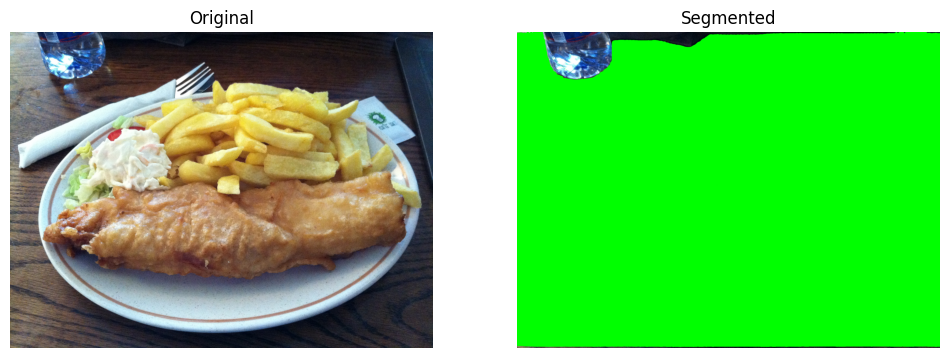

In [ ]:
from PIL import Image
import numpy as np
import supervision as sv
from google.colab.patches import cv2_imshow

# polygon = detections.mask[2][0]
# np.array([
#   [529, 702],[585, 662],[629, 614],[865, 610],[989, 822],[729, 958],[353, 1094],[389, 830],[525, 702],[525, 698],[529, 702]
# ])
polygon = np.array(arr)

h, w, _ = image_rgb.shape
frame_resolution_wh=(w, h)

zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=frame_resolution_wh)
zone_annotator = sv.PolygonZoneAnnotator(
    zone=zone,
    color=sv.Color.green(),
    thickness=1,
    text_scale=0,
    text_thickness=0,
    text_padding=0
)

frame = zone_annotator.annotate(scene=image_rgb.copy())
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

sv.plot_images_grid(
    images = [image_bgr, frame],
    grid_size = (1, 2),
    titles = ['Original', 'Segmented']
)

In [108]:
import sys
!{sys.executable} -m pip -q install IPython


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [ ]:
import cv2

im = cv2.imread(IMAGE_PATH)
h, w, c = im.shape # 1936 2592 3

mask_borders = [ mask['bbox'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]

IMAGE_SEGMENTATION = {}

content_img = f'<img src="{IMAGE_GIT_URL}" width="{w}" height="{h}" usemap="#image-map">'
content_map = '<map name="image-map">'

sorted_sam_result = sorted(sam_result, key=lambda x: x['area'], reverse=True)

for key_index, value in enumerate(sorted_sam_result):
  ssr = value

  area = ssr['area']
  bbox = ssr['bbox']
  mask = ssr['segmentation']

  index_unmask_image_name = get_unmask_image_name(key_index)
  generate_image_from_mask(mask, key_index)
  object_class = classify(index_unmask_image_name)

  IMAGE_SEGMENTATION[key_index] = dict(area = area, bbox = bbox, mask = mask, prediction=object_class)

  coords = ','.join(map(str, bbox))

  content_map += f'<area target="" alt="{index_unmask_image_name}" title="{object_class}" href="/" coords="{coords}" shape="poly">'

content_map += '</map>'

In [ ]:
import os
import IPython

content_script = """
  var images = document.querySelectorAll('img[usemap]');
        images.forEach( function(image) {
            var mapid = image.getAttribute('usemap').substr(1);
            var imagewidth = image.getAttribute('width');
            var imageheight = image.getAttribute('height');
            var imagemap = document.querySelector('map[name="'+mapid+'"]');
            var areas = imagemap.querySelectorAll('area');

            image.removeAttribute('usemap');
            imagemap.remove();

            // create wrapper container
            var wrapper = document.createElement('div');
            wrapper.classList.add('imagemap');
            image.parentNode.insertBefore(wrapper, image);
            wrapper.appendChild(image);

            areas.forEach( function(area) {
                var coordsAttributes = area.getAttribute('coords').split(' ').join('');
                var coords = coordsAttributes.split(',');
                var xcoords = [parseInt(coords[0]),parseInt(coords[0])+parseInt(coords[2])];
                var ycoords = [parseInt(coords[1]),parseInt(coords[1])+parseInt(coords[3])];
                xcoords = xcoords.sort(function(a, b){return a-b});
                ycoords = ycoords.sort(function(a, b){return a-b});
                wrapper.innerHTML += "<a href='"+area.getAttribute('href')+"' title='"+area.getAttribute('title')+"' class='area' style='left: "+((xcoords[0]/imagewidth)*100).toFixed(2)+"%; top: "+((ycoords[0]/imageheight)*100).toFixed(2)+"%; width: "+(((xcoords[1] - xcoords[0])/imagewidth)*100).toFixed(2)+"%; height: "+(((ycoords[1] - ycoords[0])/imageheight)*100).toFixed(2)+"%;'></a>";
            });
        });
"""

content_style = """
  img {max-width: 100%; height: auto;}
  .imagemap {position: relative;}
  .imagemap img {display: block;}
  .imagemap .area {display: block; position: absolute; transition: box-shadow 0.15s ease-in-out;}
  .imagemap .area:hover {box-shadow: 0px 0px 1vw rgba(0,0,0,0.5);}
"""

IPython.display.HTML('''
    <!DOCTYPE html>
    <html>
      <script>
        {content_script}
      </script>
      <style>
        {content_style}
      </style>
      <body>
        {content_img}
        {content_map}
      </body>
    </html>
'''.format(
    content_script=content_script,
    content_style=content_style,
    content_map=content_map,
    content_img=content_img
))

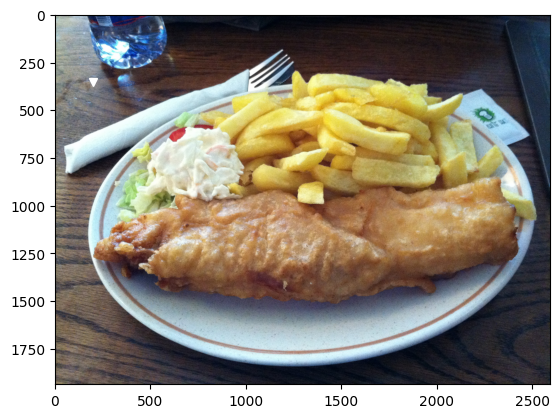

In [ ]:
from matplotlib import image
from matplotlib import pyplot as plt

def plot_image(image_path):
  # to read the image stored in the working directory
  data = image.imread(image_path)

  # to draw a point on co-ordinate (200,300)
  plt.plot(200, 350, marker='v', color="white")
  plt.imshow(data)
  plt.show()

# Mask to Image

In [ ]:
import matplotlib.pyplot as plt

def get_unmask_image_name(mask_index, image_name):
  return os.path.join(HOME, 'data', f'{mask_index}_unmask_{image_name}')

def get_mask_image_name(mask_index, image_name):
  return os.path.join(HOME, 'data', f'{mask_index}_mask_{image_name}')

def generate_image_from_mask(mask_by_sam, mask_index):
  mask_image_path   = get_mask_image_name(mask_index)
  unmask_image_path = get_unmask_image_name(mask_index)

  data = Image.fromarray(mask_by_sam)
  data.save(mask_image_path)

  img = cv2.imread(IMAGE_PATH)
  mask = cv2.imread(mask_image_path, 0)

  res = cv2.bitwise_and(img, img, mask = mask)
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2GRAY

  data = Image.fromarray(res)
  data.save(unmask_image_path)

# deprecated
def generate_image_from_mask_batch():
  MASK_RANGE = range(len(masks))

  for mask_index in MASK_RANGE:
    if mask_index == 90:
      mask_image_path = os.path.join(HOME, "data", f'{mask_index}_mask_{IMAGE_NAME}')
      data = Image.fromarray(masks[mask_index])
      data.save(mask_image_path)

      img = cv2.imread(IMAGE_PATH)
      mask = cv2.imread(mask_image_path, 0)
      res = cv2.bitwise_and(img, img, mask = mask)
      res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2GRAY

      data = Image.fromarray(res)
      data.save(f'{mask_index}_unmask_{IMAGE_NAME}')

In [ ]:
import gradio as gr

row_range = range(1)

def launch_demo():
  with gr.Blocks() as demo:
      with gr.Row():
        for mask_index in row_range:
          gr.Image(get_unmask_image_name(mask_index), scale=1)

      gr.Dropdown(["chocolate cake", "ramen", "sushi"], label="Food 101", info="Select one"),

  demo.launch()

# Classification

In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
from PIL import Image

def setup():
  global processor, clip_labels, model, labels, imagenette

  image_path = IMAGE_PATH
  # show dataset info
  imagenette = load_dataset('food101')

  labels = imagenette['train'].features['label'].names

  # generate sentences
  clip_labels = [f"a photo of a {label}" for label in labels]

  # initialization
  model_id = "openai/clip-vit-base-patch32"

  processor = CLIPProcessor.from_pretrained(model_id)
  model = CLIPModel.from_pretrained(model_id)

def classify(image_path):
  # create label tokens
  label_tokens = processor(
      text=clip_labels,
      padding=True,
      images=None,
      return_tensors='pt'
  ).to(DEVICE)

  # encode tokens to sentence embeddings
  label_emb = model.to(DEVICE).get_text_features(**label_tokens)

  # detach from pytorch gradient computation
  label_emb = label_emb.detach().cpu().numpy()

  # normalization
  label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
  # image_path = os.path.join(HOME, image_path)

  image = processor(
      text=None,
      images=Image.open(image_path),
      return_tensors='pt'
  )['pixel_values'].to(DEVICE)

  img_emb = model.get_image_features(image)
  img_emb = img_emb.detach().cpu().numpy()
  scores = np.dot(img_emb, label_emb.T)
  pred = np.argmax(scores)

  return labels[pred]

In [ ]:
def combine_masks(m1, m2, combine_mask_path):
  mask1 = cv2.imread(m1)
  mask2 = cv2.imread(m2)

  merged_masks = cv2.bitwise_or(mask1, mask2)
  merged_masks = Image.fromarray(merged_masks)
  merged_masks.save(combine_mask_path)

In [ ]:
# import pprint

# print(type(sam_result))
# print(sam_result[0].keys())
# print(len(sam_result))
# print(sam_result[0]['predicted_iou'])
# print(sam_result[0]['point_coords'])
# print(sam_result[0]['crop_box'])
# print(type(detections))

# seg_mat = sam_result[9]['segmentation']
# x_start, y_start, x_length, y_length = sam_result[9]['bbox']
# print(x_start, y_start, x_length, y_length)

# spots = []
# for col in range(y_start, y_start + y_length):
#   for row in range(x_start, x_start + x_length):
#     if not seg_mat[row][col]:
#       spots.append(str(row))
#       spots.append(str(col))

# print(','.join(spots))

# pp = pprint.PrettyPrinter(indent=4)
# for i in range(len(sam_result)):
#   pp.pprint(f"{i}. {sam_result[i]['point_coords']} / {sam_result[i]['bbox']} / {sam_result[i]['crop_box']}")

1269 876 140 118
1269,876,1270,876,1271,876,1272,876,1273,876,1274,876,1275,876,1276,876,1277,876,1278,876,1279,876,1280,876,1281,876,1282,876,1283,876,1284,876,1285,876,1286,876,1287,876,1288,876,1289,876,1290,876,1291,876,1292,876,1293,876,1294,876,1295,876,1296,876,1297,876,1298,876,1299,876,1300,876,1301,876,1302,876,1303,876,1304,876,1305,876,1306,876,1307,876,1308,876,1309,876,1310,876,1311,876,1312,876,1313,876,1314,876,1315,876,1316,876,1317,876,1318,876,1319,876,1320,876,1321,876,1322,876,1323,876,1324,876,1325,876,1326,876,1327,876,1328,876,1329,876,1330,876,1331,876,1332,876,1333,876,1334,876,1335,876,1336,876,1337,876,1338,876,1339,876,1340,876,1341,876,1342,876,1343,876,1344,876,1345,876,1346,876,1347,876,1348,876,1349,876,1350,876,1351,876,1352,876,1353,876,1354,876,1355,876,1356,876,1357,876,1358,876,1359,876,1360,876,1361,876,1362,876,1363,876,1364,876,1365,876,1366,876,1367,876,1368,876,1369,876,1370,876,1371,876,1372,876,1373,876,1374,876,1375,876,1376,876,1377,876,13